# Finding the optimal placement for a H2 production facility

## Bring the data that is needed

In [2]:
%reset -f
import copy
import math
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import combinations
from disaggregator import config, data, spatial, plot
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

### Bring the shapes

In [3]:
nuts = data.database_shapes()
nuts = nuts.drop(columns = ["id_ags", "gen", "fl_km2"])

### Bring the pipes
We use two different sources:
 * `germanPipesMerged.json` uses data from EMAT, IGGI, INET, LKD
 * `germanPipesRaw.json` uses data from IGGIELGN

It seems that although the dataset IGGIELGN should have the data from all the afore mentioned sources, some pipelines are still missing.

In [4]:
with open("project_data/in/germanPipesMerged.json", 'r', encoding = 'utf-8') as file:
    pipes = json.load(file)

with open("project_data/in/germanPipesRaw.json", 'r', encoding = 'utf-8') as file:
    pipes2 = json.load(file)

#### Mix the pipes data together

We read every pipe in the first data source, and add the coordinates to a list. This list will be useful when reading from the second source, to prevent duplicates from entering the final list (named `pipes`).

We then also transform all the unique pipes from `pipes` into lines for later plotting.

In [5]:
coords = []
listPipesLengths = []

for p in pipes:
    if (p["geometry"]["coordinates"] in coords): continue
    coords.append(p["geometry"]["coordinates"])
    listPipesLengths.append(p["properties"]["param"]["length_km"])

for p in pipes2:
    if (p["geometry"]["coordinates"] in coords): continue
    pipes.append(p)
    listPipesLengths.append(p["properties"]["param"]["length_km"])

pPlots = []

for p in pipes:
    pPlots.append(LineString( p["geometry"]["coordinates"] ))

pPlots = gpd.GeoDataFrame(geometry = pPlots, crs = "EPSG:4326")
pPlots = pPlots.to_crs("EPSG:25832")

#### Discretize the data into NUTS3 districts

Once the pipes have been brought, we need to simplify the analysis. For this we won't say that a pipe X leaves from Y, Z coordinates. Instead we will say that it leaves from a district A. The naming convention of the districts follows the Eurostat NUTS 3 nomenclature of territorial units.

This simplified model of the pipes will be stored in the variable `finalPipes`. It will have 2 columns : origin and destination.

##### Use the given data when possible

First, we use the NUTS 3 information that is already given for some pipes.

In [6]:
finalPipes = gpd.GeoDataFrame(columns = ["origin", "destination"])
finalPipes["origin"]      = ["XX"] * len(pPlots)
finalPipes["destination"] = ["XX"] * len(pPlots)

for index, row in finalPipes.iterrows():
    if (not "nuts_id_3" in pipes[index]["properties"]["param"] or len(pipes[index]["properties"]["param"]["nuts_id_3"]) == 1): continue # Do not continue if there are no nuts 3 info
    
    if (pipes[index]["properties"]["param"]["nuts_id_3"][0][0:2] == "DE"): row["origin"] = pipes[index]["properties"]["param"]["nuts_id_3"][0]
    if (pipes[index]["properties"]["param"]["nuts_id_3"][1][0:2] == "DE"): row["destination"] = pipes[index]["properties"]["param"]["nuts_id_3"][1]

##### Find the district when not given

When the NUTS 3 district is not given, we use the `sjoin` function for the pipes. This will tell us in what district the origin or destination coordinates lie.

In [7]:
def get_start_end_points(line):
    return {'Start': line.coords[0], 'End': line.coords[-1]}

# Apply the function to create a new GeoDataFrame with start and end points
points_data = pPlots['geometry'].apply(get_start_end_points).apply(pd.Series)

# Create a new GeoDataFrame with the points
start_Points = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['Start']], crs="EPSG:25832")
end_Points   = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['End']], crs="EPSG:25832")

resultStart = gpd.sjoin(start_Points, nuts, how="left").rename(columns={'geometry': 'geomS', 'index_right': 'indexS'})
resultEnd   = gpd.sjoin(end_Points, nuts, how="left").rename(columns={'geometry': 'geomE', 'index_right': 'indexE'})

joinPipes = pd.concat([resultStart, resultEnd], axis = 1)
joinPipes = joinPipes.reset_index(drop = True)
joinPipes = joinPipes.drop(columns = ["geomS", "geomE"]).rename(columns = {"indexS": "origin", "indexE": "destination"})

for index, row in finalPipes.iterrows():
    if (row["origin"] == "XX" and type(joinPipes.loc[index, "origin"]) == type("")):
        row["origin"] = joinPipes.loc[index, "origin"]
    if (row["destination"] == "XX" and type(joinPipes.loc[index, "destination"]) == type("")):
        row["destination"] = joinPipes.loc[index, "destination"]

#### Double directionned pipes

Now that we have all the pipes districts, we can start working with the pipes. First, we will copy and invert all the pipes that can be used in both directions.

In [8]:
indexesToInvert = []

for p in pipes:
    if ("is_bothDirection" in p["properties"]["param"] and p["properties"]["param"]["is_bothDirection"]): indexesToInvert.append(index)

for index in indexesToInvert:
    finalPipes.loc[len(finalPipes)] = [finalPipes.loc[index, "destination"],finalPipes.loc[index, "origin"]] 
    listPipesLengths.append(listPipesLengths[index])

#### Pipes within the same district

We will also remove the pipes that do from a district to itself.

In [9]:
indexesToRemove = [] # These indexes indicate pipes that go from a district to itself

for index, row in finalPipes.iterrows():
    if (row["origin"] == row["destination"]): indexesToRemove.append(index)

finalPipes = finalPipes.drop(indexesToRemove)

for i in range(len(indexesToRemove) - 1, -1, -1):
    del listPipesLengths[indexesToRemove[i]]

#### Outgoing or Incoming pipes

If a pipe going **into** a district, set `comingIn` in that district to 1. Same for `outGoing` gas.

In [10]:
pipesDestination = nuts.copy().drop(columns = ["geometry"])

pipesDestination["comingIn"] = np.zeros(401)
pipesDestination["outGoing"] = np.zeros(401)

for _, p in finalPipes.iterrows():
    pipesDestination.loc[p["origin"], "outGoing"] = 1
    pipesDestination.loc[p["destination"], "comingIn"] = 1

Display the results, here we can see where the gas is coming and where the gas can arrive and where the gas can leave from.

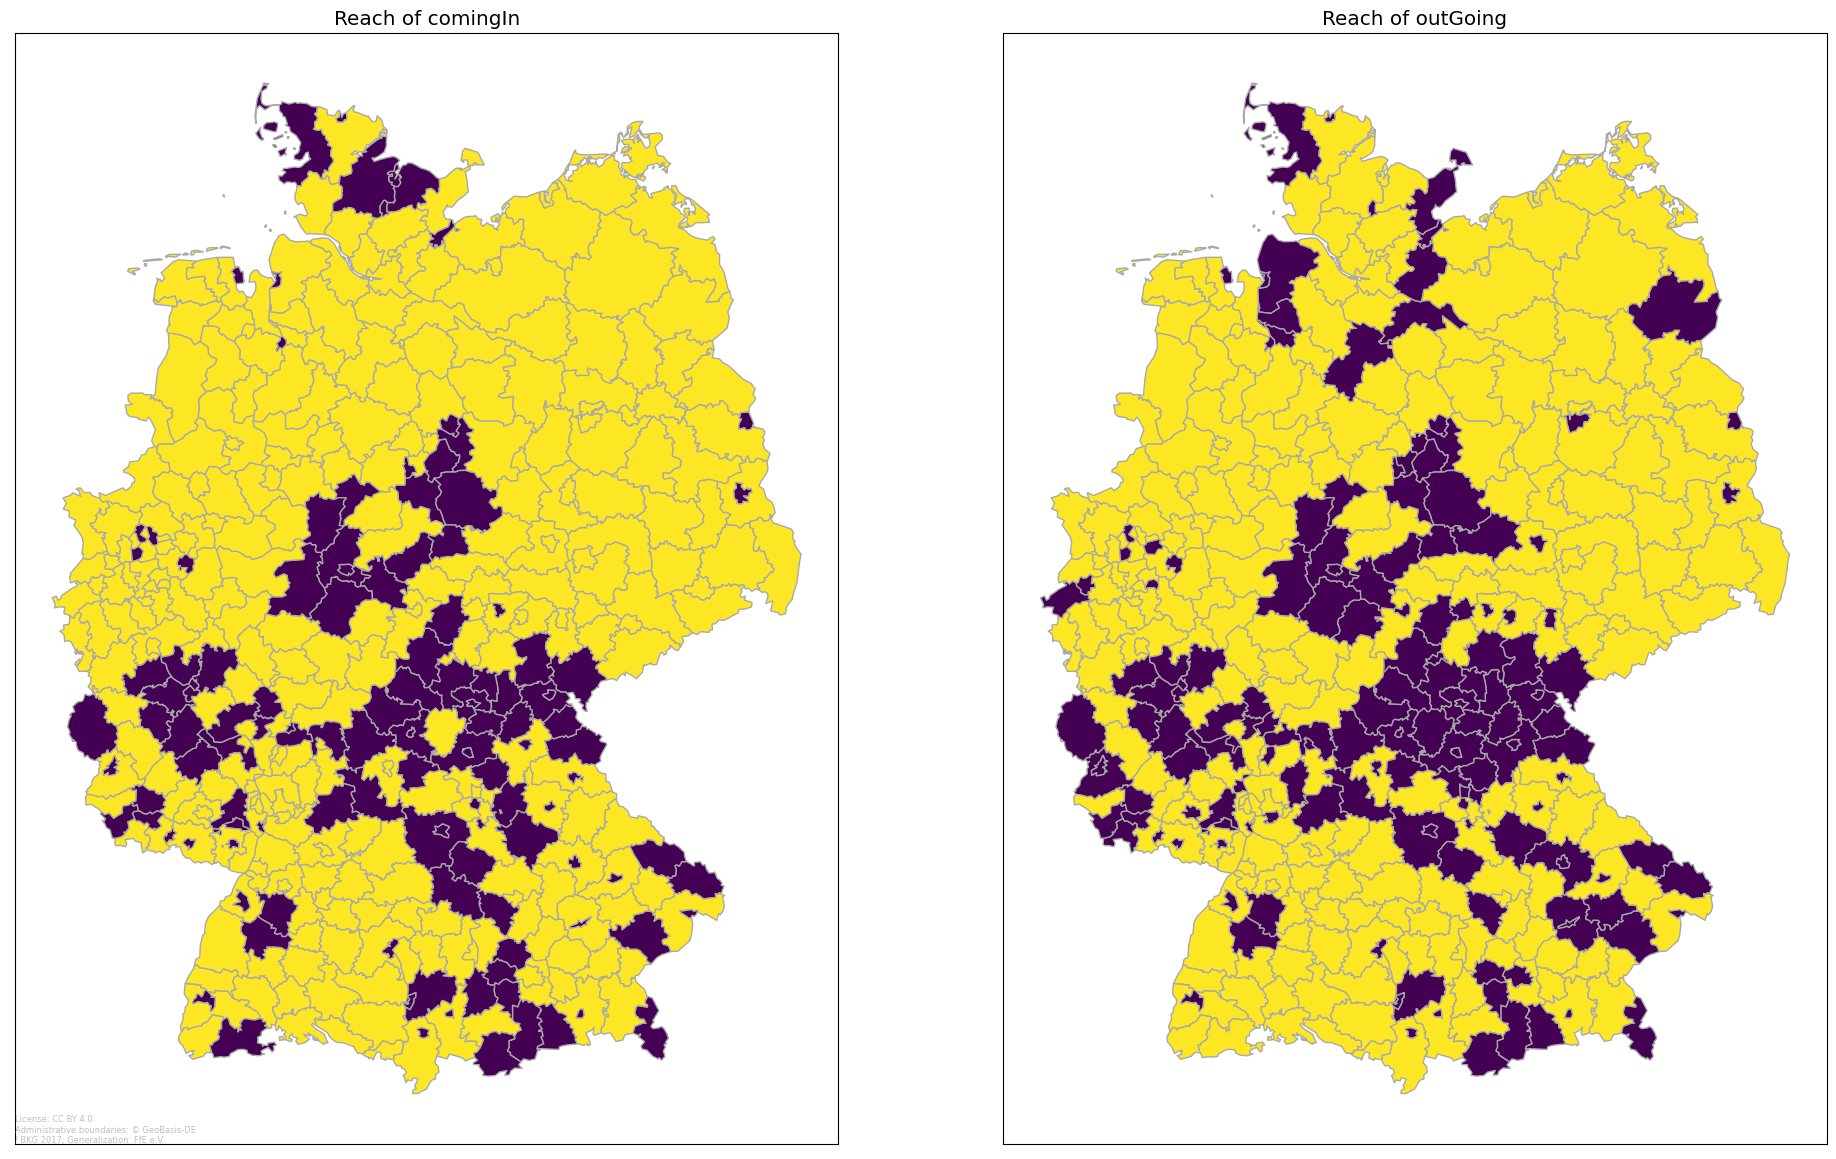

In [17]:
fig, axs = plot.choropleth_map(pipesDestination, axtitle = "Reach of", unit= "GWh", relative = False, hide_colorbar = True) # Relative = divide by area

fig.savefig('project_data/out/Images/3_pipes_reach.png', dpi=300)  # Save the figure with DPI set to 300

#### Only out

For later, it will be useful to find the pipes that only receive.

In [10]:
pipesDestination["onlyOut"] = np.zeros(402)

onlyReceivers = []

for index, row in pipesDestination.iterrows():
    row["onlyOut"] = (int(row["outGoing"]) ^ int(row["comingIn"])) & int(row["outGoing"])
    if (row["onlyOut"] == 1): onlyReceivers.append(index)

print(onlyReceivers)

['DE13A', 'DE217', 'DE21E', 'DE259', 'DE27D', 'DE713', 'DEA32', 'DEF02', 'DEF0A', 'DEF0B']


### Pipes diameters

For later it will be useful to know the diameter of all the pipes, as gas normally flows from big pipes into smaller ones. The diameter of the pipe is given for most of the pipes, however some pipes don't have it.

#### Given diameter

The diameter of the pipe is taken from the dataset for all the pipes that have it. For those that don't have it, we will use the other pipes found as a reference.

In [11]:
finalDiameters = []

X = [] # Length (km)
Y = [] # Diameter (mm)

unknownD = [] # Unknown diameters

for i, p in enumerate(pipes):
    if (i in indexesToRemove): continue
    
    if ("diameter_mm" in p["properties"]["param"] and p["properties"]["param"]["diameter_mm"] != None):
        X.append(p["properties"]["param"]["length_km"])
        Y.append(p["properties"]["param"]["diameter_mm"])
        finalDiameters.append(p["properties"]["param"]["diameter_mm"])
    else:
        unknownD.append(p["properties"]["param"]["length_km"])
        finalDiameters.append(None)

#### Missing diameters

##### Using existing pipes to approximate the diameter

For the pipes whose diameter we are missing, we first use the `find_closest_number` function. This functions finds a pipe whose lenght is within an n percentage of the pipe's length, whose diameter is unknown. We then keep the one whose's length is the closest, and use its diameter.

##### Heuristic method to compute the diameter

This doesn't work for all the pipes. However, since all of the pipes' lenght is less than 1km, we can assume that they all have a diameter of 200mm.

In [12]:
def find_closest_number(D, X, n):
    maxDiff = 1 + (D * n/100)
    nRet = None
    for num in X:
        if (D * (1 - n/100) <= num <= D * (1 + n/100)):
            if (abs(num - D) < maxDiff):
                nRet = num
                maxDiff = abs(num - D)
    return nRet

estimatedD = []

n = 5 # 5% difference
for D in unknownD:
    result = find_closest_number(D, X, n)
    
    if (result is not None):  estimatedD.append(Y[X.index(result)])
    else: estimatedD.append(200)

#### Merging the values

Now that we have found all the diameters, we can put them together in a single list (`finalDiameter`).

In [13]:
for i in range(len(finalDiameters)):
    if (finalDiameters[i] == None):
        finalDiameters[i] = estimatedD.pop(0)

print(len(estimatedD)) # 0 means it has worked as intented

0


This is the last check to verify that both arrays have the same size.

In [16]:
print(len(finalDiameters), len(finalPipes.index), len(listPipesLengths))

1502 1502 1502


#### Saving the values

We first prepare the data as a dictionary, so that it can be called from a pipe going from a district A to B.

In [14]:
diamDic = {}

cols = []
for column in finalPipes.columns:
    cols.append(finalPipes[column].tolist())


for i in range(len(finalDiameters)):
    org = cols[0][i]
    dst = cols[1][i]
    
    if (not org in diamDic): diamDic[org] = {}
    
    diamDic[org][dst] = finalDiameters[i]

with open("project_data/out/diameters.json", 'w') as file:
    json.dump(diamDic, file, indent = 4)

### Pipes lenghts

Fortunately, for the pipes' lenghts, there's always the pipe length attribute stating the pipe's lenght. We just store it in a dictionnary for later easy access, and save it into a json file.

In [15]:
pipesLengths = {}

index = 0
for _, row in finalPipes.iterrows():
    if (row["origin"] not in pipesLengths): pipesLengths[row["origin"]] = {}
    
    pipesLengths[row["origin"]][row["destination"]] = listPipesLengths[index]
    index += 1

with open("project_data/out/lengths.json", 'w') as file:
    json.dump(pipesLengths, file)

## Map creation

In this next cell we compute all the possible places where gas can go from a starting point $A$ to an end point $Z$ taking a path $P$.

The algorithm used is DFS, it uses a recursive function `find_path`. It receives a starting node `start` and an end node to reach `end`. To reach this point, it will examine all the neighboring nodes of `start`. It will choose one (`node`) and before going deeper two conditions must be satified :

 * `node` is not "XX", meaning that we cannot use pipes going outside of Germany to ensure gas distribution accross Germany.
 * The diameter from the previous node (the one before `start`) to the current node (`start`) must be larger of equal to the diameter of the next pipe (going from `start` to `node`).

If these two conditions are satified, the function calls itself with the new `start` point being `node`, and `node` being one of the neighbors of `start`.

Once this has gone through all the possible connections (with the exception of $A \rightarrow A$ or $A \rightarrow "XX"$).

Some notable optimizations taken are that :
 1. A list of the nodes that are only receivers has been created so that these nodes are not called by the search algorithm.
 2. A diameter check has been done so that the diameter of the next pipe can only be smaller or equal.
 3. A parameter `max_depth` has been set so that the algorithm doesn't go too far. This was useful before introducing the diameter check. This limited the search time allocated to each connection. If a connection couldn't be made in `maxD` recursions it was added to a list to be done latter with a bigger `max_depth` parameter.
 4. The Conections dictionary was used so that each connection could look up, after moving to a neighbor node, if there is already a path going from the current node being considered and the end point.

In [19]:
import json
import copy

with open("lines.json", 'r') as file:
    Lines = json.load(file)

with open("diameters.json", 'r') as file:
    Diameters = json.load(file)

with open("lengths.json", 'r') as file:
    Lenghts = json.load(file)

i = 0
j = 0

diamDiff = 0 # % Between 0 and 1. It represents the % that we accept for a bigger pipe to receiver from a smaller one. For example a 200mm can give to a 220mm with diamDiff = 0.1 (10%)

Nodes = {}
Conections = {}

onlyReceivers = ['DE13A', 'DE217', 'DE21E', 'DE259', 'DE27D', 'DE713', 'DEA32', 'DEF02', 'DEF0A', 'DEF0B'] # These districts only receive, so no point in searching through them

toRedo = [] # These are connexions that reached the max_depth

def guardar(txt):
    print("Saving data", txt)
    with open("connections" + txt + ".json", 'w') as file:
        json.dump(Conections, file, indent = 4)

def getLength(path):
    distance = 0
    
    for i in range(len(path) - 1):
        distance += Lenghts[path[i]][path[i + 1]]
    
    return distance

# Init
for L in Lines:
    if (not L[0] in Nodes): Nodes[L[0]] = set()
    if (not L[1] in Nodes): Nodes[L[1]] = set()

for L in Lines: Nodes[L[0]].add(L[1])

# Delete those that only receive since they don't send
for rec in onlyReceivers:
    if (rec in Conections): del Conections[rec]

# Verify diameters
for L in Lines:
    if (not L[0] in Diameters):
        print("Missing node", L[0])
        continue
    
    if (not L[1] in Diameters[L[0]]): print("Missing diameter for connexion", L[0], L[1])

def find_all_paths(graph, start, end, path = [], depth = 0, max_depth = None):
    if (max_depth is not None and depth > max_depth): return [-1]
    
    path = path + [start]
    if start == end: return [path]
    if start not in graph: return []
    
    paths = []
    
    for node in graph[start]:
        if node not in path and node != "XX":  # Ignore the routes that go outside Germany
            if(len(path) >= 2 and Diameters[path[-2]][start] >= Diameters[start][node] * (1 + diamDiff)): continue
            
            newpaths = find_all_paths(graph, node, end, path, depth + 1, None)
            for newpath in newpaths:
                paths.append(newpath)
    
    return paths

for start_node in Nodes:
    print("Done", i, "/", len(Nodes))
    i += 1
    
    if (start_node in onlyReceivers): continue
    
    if (start_node == "XX"): continue
    j = 0
    for end_node in Nodes:
        print("Node", i, "doing", j, '/', len(Nodes))
        j += 1
        
        if (end_node == "XX"): continue
        if (start_node == end_node): continue
        
        routes = find_all_paths(Nodes, start_node, end_node, max_depth = None)
        
        if (routes == [-1]):    # We reached the max_depth, we can redo them later with an increased bound
            toRedo.append([start_node, end_node])
            print("Redo the relation between", toRedo[-1][0], "and", toRedo[-1][1])
            continue
        
        if (not routes == None and len(routes) == 0): continue
            
        if (not start_node in Conections): Conections[start_node] = {}
        
        # Keep the shortest route
        routeToWrite = []
        
        if (len(routes) > 1):
            
            length = float("inf")
            
            for route in routes:
                lRoute = getLength(route)
                
                if (lRoute < length):
                    lRoute = length
                    routeToWrite = route
            
        else: routeToWrite = routes[0]
        
        Conections[start_node][end_node] = copy.deepcopy(routeToWrite)

guardar("_O_final")

FileNotFoundError: [Errno 2] No such file or directory: 'lines.json'

## Computing the hydrogen demand

Now that we have prepared all the German infrastructure (pipes), we can focus on the hydrogen demand.

### Residential sector

#### Finding the current hydrogen consumption

We will use the current gas consumption profile to base what would be the future hydrogen profile. To find the demand from the residential sector, we will use the current gas demand in MWh/yr. Then, we will transform it into hydrogen demand in kgH2/d with a percentage `b` of blending.

We can find the quantity of hydrogen needed by solving the following equation:

\begin{align}
 W_{Tot} &= \eta_{H_2} M_{H_2} HV_{H_2} + \eta_{CH_4} M_{CH_4} HV_{CH_4} \\ 
 M_{Tot} &= M_{H_2} + M_{CH_4} \\ 
 M_{H_2} &= b \, M_{Tot} 
\end{align}

Therefore,

$$ M_{H_2} = \frac{W}{\eta_{CH_4} \frac{1 - b}{b}HV_{CH_4} + \eta_{H_2} HV_{H_2} } $$

In [2]:
gasUsage = spatial.disagg_households_gas(how = "top-down") # MWh / a
gasUse = gasUsage.sum(axis = 1) * 1000 / 365 # Sum the Cooking + HotWater + SpaceHeating to have total gas usage kWh / d

b = 1 # % of H2

HVch4 = 14.583 # kWh / kgCH4
HVh2  = 33.33  # kWh / kgH2

etaH2  = 0.83 # https://ieeexplore.ieee.org/abstract/document/7275758
etaCH4 = 0.94

gasUse = gasUse / ( ( (etaCH4 * (1 - b) / b) * HVch4) + (etaH2 * HVh2))

NameError: name 'spatial' is not defined

#### Scaling the demand

The hydrogen demand is expected to be of 95TWh hydrogen per year as found in [this](https://www.reuters.com/business/energy/german-cabinet-approves-updated-national-hydrogen-strategy-2023-07-26/) article. This consumption would correspond to ~2.85 Mton H2 per year.

> But even with doubling the country's domestic electrolysis capacity target for 2030 to at least 10 gigawatts (GW), Germany will need to import around 50% to 70% of its hydrogen demand, forecast at 95 to 130 TWh in 2030, the strategy showed.

In [16]:
germanHydrogenDemandTWh = 95 # TWh/yr
importRatio = 0.5 # %
germanHydrogenDemand = (1 - importRatio) * germanHydrogenDemandTWh * 1e9 / HVh2 / 365 # TWh/yr * 1e9 kWh/TWh * 33.33 kgH2/kWh * (1/365) yr/d

print("Hydrogen daily demand considering", int(100 * b), "% :", gasUse.sum())
print("Hydrogen daily local production considering an annual demand of", germanHydrogenDemandTWh, "TWh and an import ratio of", int(100 * importRatio), '% :', germanHydrogenDemand)
print("which translates to", germanHydrogenDemand * 365 / 1e9 / (1 - importRatio), "Mton H2 annualy")

gasUse = germanHydrogenDemand * gasUse / gasUse.sum()

NameError: name 'HVh2' is not defined

### Industrial sector

Now that we have the residential demand, we will compute the industry demand. As for the residential, the unit we will work on will be kgH2/d.

In [66]:
files = ["amonia.json", "refineries.json", "steel.json"]

importData = []

for file in files:
    with open("project_data/in/" + file, 'r', encoding = "utf-8") as f:
        importData.append(json.load(f))

toDelete = []
points = []

for i, dataE in enumerate(importData):
    temp = []
    for element in dataE:
        if (element["Latitude"] == ""):
            toDelete.append(element)
            continue
        
        if (i == 1 and element["Product"] != "Crude"): # Keep only the crude production
            toDelete.append(element)
            continue
        
        if (i == 2 and element["Process"] == "Electric"): # Keep only high furnaces
            toDelete.append(element)
            continue
              
        element["geometry"] = [float(element["Longitude"]), float(element["Latitude"])]

        del element["Latitude"]
        del element["Longitude"]
        
        temp.append(Point(element["geometry"][0], element["geometry"][1]))
    points.append(temp)

for toD in toDelete: # Delete the industry that doesn't have coordinates
    for dataE in importData:
        if (not toD in dataE): continue
        dataE.remove(toD)

amonia = copy.deepcopy(importData[0])
refineries = copy.deepcopy(importData[1])
steel = copy.deepcopy(importData[2])

aPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[0]), crs = "EPSG:4326")
rPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[1]), crs = "EPSG:4326")
sPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[2]), crs = "EPSG:4326")

aPoints = aPoints.to_crs("EPSG:25832")
rPoints = rPoints.to_crs("EPSG:25832")
sPoints = sPoints.to_crs("EPSG:25832")

aPoints["consumption"] = [(int(a["Production"]) * 1000 * 176.14 / 1000 / 365) for a in amonia]          # In kgH2 / d
rPoints["consumption"] = [(int(r["Production"]) * 1000 * 1.02 / 227.69 / 365) for r in refineries]      # In kgH2 / d
sPoints["consumption"] = [(int(s["Production"]) * 1000 * 0.97 * 54.171367 / 1000 / 365) for s in steel] # In kgH2 / d

aPoints = gpd.sjoin(aPoints, nuts)
rPoints = gpd.sjoin(rPoints, nuts)
sPoints = gpd.sjoin(sPoints, nuts)

### Finding the total hydrogen demand

For this we will simply add the residential and industry demand per district. For accessing this demand, we will use the variable `pipesDestination["h2Need"]` that stores how much hydrogen each district needs.

In [67]:
pipesDestination["h2Need"] = pipesDestination["comingIn"] * gasUse

for index, row in aPoints.iterrows():
    pipesDestination.loc[row["index_right"], "h2Need"] += row["consumption"]
    
for index, row in rPoints.iterrows():
    pipesDestination.loc[row["index_right"], "h2Need"] += row["consumption"]

for index, row in sPoints.iterrows():
    pipesDestination.loc[row["index_right"], "h2Need"] += row["consumption"]

if ("XX" in list(pipesDestination.index)): pipesDestination = pipesDestination.drop("XX")

In [125]:
with open("project_data/out/pipesDestination.json", 'w') as file:
    json.dump(pipesDestination.to_dict(), file)

### Computing how much demand can each point serve

Now that we know what districts are connected (dictionary `Connections`) and what is the hydrogen need of each district (`pipesDestination["h2Need"]`), we can compute how much hydrogen would each district be able to give. That is, we will iterate through every node with out going pipes and add the hydrogen demand of every district it can access through pipes. We will then store this hydrogen demand in the variable `nodeServing["gasDemand"]`.

In [44]:
with open("project_data/in/connections_O_10.json", 'r') as file:
    Connections = json.load(file)

In [45]:
nodeServing = nuts.copy() # nodeServing has a column
nodeServing = nodeServing.drop(columns = ["geometry"])
nodeServing["gasDemand"] = np.zeros(401)

for node in Connections:
    temp = 0
    
    for destination in Connections[node]:
        if (destination == "XX"): continue
        
        if (Connections[node][destination] != None):
            temp += pipesDestination.loc[destination, "h2Need"]
    
    nodeServing.loc[node, "gasDemand"] = temp

We can now compute the daily nad yearly hydrogen demand in kgH2

In [46]:
print(int(pipesDestination["h2Need"].sum()), int(365 * pipesDestination["h2Need"].sum()))

10056168 3670501516


In [24]:
print(int(gasUse.sum()), int(365 * gasUse.sum()))

19823900 7235723572


So I looked it up, and effectively, German houses consume **that** much gas https://www.dw.com/en/germans-cut-household-gas-consumption-amid-ukraine-war-and-warm-weather/a-63512854

In [1]:
(gasUsage.sum(axis = 1) * 1000 / 365).sum() / 1e6 # GWh/day

NameError: name 'gasUsage' is not defined

How can can the most well connected point serve ?

In [48]:
print(100 * max(nodeServing["gasDemand"]) / pipesDestination["h2Need"].sum(), '%')

34.625048313475425 %


## Clustering

Once we know how much hydrogen each district needs and how much each district can give, we can now find the places where we can place our hydrogen production plants. The first approach was to brute force all the possible combinations of n districts, whose serving sum (without duplicates) was equal to more than the set threshold. This was a bad idea, as the number of combinations follows the following formula: $C\binom{280}{n}$. For $n$ = 3, this becomes too much to run, making another solution necessary.


| n | $C \binom{280}{n}$ |
|-----|--------------------|
|  1  |         280        |
|  2  |       39 060       |
|  3  |      3 619 560     |
|  4  |     250 654 530    |
|  5  |   13 836 130 056   |

The idea uses the centroids of the districts shapes and assigns them a weight. This weight is the hydrogen demand of the district. This makes it so when clustering the district, it will not only consider their position, but also their hydrogen need.

In [49]:
districtsCentroids = gpd.GeoDataFrame(geometry = nuts.centroid, crs = "EPSG:25832")
data = np.column_stack((nuts.centroid.x, nuts.centroid.y, pipesDestination["h2Need"].values)) # Coords of the points

def computeCentroids(n):
    max_demand = np.max(data[:, 2]) # Normalize the energy demand
    data[:, 2] /= max_demand

    # Create a weight array where the weight is the energy demand
    weights = data[:, 2]

    # Perform weighted k-means clustering
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(data[:, :2], sample_weight=weights)

    return kmeans.cluster_centers_ # Centroids of the clusters

## Computing the TOTEX

### CAPEX equation

This equation was taken from [Wind-To-Hydrogen Project: Electrolyzer Capital Cost Study](https://doi.org/10.2172/944892), more precisely in page 15 where it is stated that the capital cost of the electrolyzer can be found as:

$$ y = 224.49 * x^{0.6156} $$

where $y$ is expressed in thousand (2008) dollars and $x$ is expressed in kg H2/hr.

#### Bringing the 2008 dollars into 2022 dollars

Since this data is old, inflation has made the past dollars have more buying power than 2022 dollars. To make bring it more into today, we use the CEPCI coefficient. The values for 2008 (CAPEX equation) and July 2023 ([latest data](https://toweringskills.com/financial-analysis/cost-indices/)) were found to be :

|   **Year**    | **CEPCI** |
|---------------|-----------|
|   2008        |   575.4   |
|   2023 July   |   798.3   |

In [50]:
def electrolysisCAPEX(outC): # outC is the output capacity in kg/d
    m = outC / 24 # kg/hr
    
    CAPEX = 224.49 * m**(0.6156) # https://www.nrel.gov/docs/fy09osti/44103.pdf p.21
    CAPEX *= 1000 # In 2008 dollars
    
    CEPCI2022 = 798.3 # 07.2023
    CEPCI2008 = 575.4 #    2008
    
    return CAPEX * (CEPCI2022 / CEPCI2008)

### OPEX equation

For the OPEX, as read from [Assessment of Hydrogen Production Costs from Electrolysis: United States and Europe](https://theicct.org/publication/assessment-of-hydrogen-production-costs-from-electrolysis-united-states-and-europe/) we can assume either say that the OPEX is equal to between 1-3%, or that it is equal to 50\$/kWh. In my case I chose to go with the fixed price per kWh.

In [51]:
def electrolysisOPEX(outC):
    totalEnergy = outC * 365 / 39.39 # kWh/yr
    return 50 * 0.94 * outC # Assuming a 3% of the CAPEX (worst case) [https://theicct.org/wp-content/uploads/2021/06/final_icct2020_assessment_of-_hydrogen_production_costs-v2.pdf p.27]

### Annualization

Large projects aren't paid all at once. Most often that not, the payments are split among the length of time of the project with a certain percentage added. To take this into account, and be able to compare the OPEX (which is per year) with the CAPEX (which is total), we can use the `anualize` function on the OPEX. The anualization factor is the following :

$$ \tau = \frac{ i (1 + i)^n}{(1 + i)^n - 1} $$

In [68]:
def anualize(cost, n, i):
    return cost * (i * (1 + i)**n) / ( (1 + i)**n - 1)

In [52]:
def generate_combinations(elements):
    if (len(elements) == 0): return []

    combinations = [[]]

    for element_list in elements:
        new_combinations = []
        for combination in combinations:
            for element in element_list:
                new_combination = combination.copy()
                new_combination.append(element)
                new_combinations.append(new_combination)
        combinations = new_combinations

    return combinations

In [53]:
def getDistancePath(path): # Returns the length of a path by adding the length between all the points inside of a path
    distance = 0
    
    for i in range(len(path) - 1):
        distance += pipesLengths[path[i]][path[i + 1]]
    
    return distance

In [54]:
def getDestinations(node): # Returns all the districts accessible to a district
    temp = []
    
    for n in Connections[node]:
        if (Connections[node][n] != None): temp.append(n)
    
    return temp

### Finding the lowest CAPEX

In this function we compute the CAPEX of n plants. To do so, we first need to find how much hydrogen each plant would need to produce. This is simply found as the sum of all the needs of all the districts that a plant serves. One slight problem is that from two different plant locations can serve the same district. We will therefore need to delete the duplicates. The end district that appears more than once will only be kept by the plant that has it the closest.

A safety check has been put into place to ensure that all the plants have at least 1 destination to whom give hydrogen.

Now that we know there are not duplicates and every plant has production ensured, we will calculate how much hydrogen need does each plant see. To do so, we will simply add the hydrogen need of each end-district of a given plant. This quantity will be useful later.

Once we have all this hydrogen needs, we can compute how much hydrogen should each plant produce. Once first approximation is to say that the hydrogen demand to be satisfied locally should be split equally among all the plants. However, it may happen that the hydrogen need from one plant location is not high enough, and so the plant would be producing useless hydrogen. What is done instead is that, this "excess" production is given to a different plant that has a higher hydrogen need. This process of computing the excess hydrogen production and giving it to a different plant location is repeated untill the total hydrogen demand to be satisfied is met.

We can now go through each plant's production and compute the CAPEX by calling the function `electrolysisCAPEX` which takes the production of a plant in kgH2/d and returns the CAPEX.

The function `computeCapex` not only returns the total CAPEX (i.e. the sum of the CAPEX of all the plants), but also the CAPEX of each plant. The contribution of each plant in kgH2/d and the districts each plant serves. 

**TODO : REWRITE AND BRING THE SOCIAL IMPACT**

In [55]:
threshold = germanHydrogenDemand # in kgH2

def computeCapex(plantsLocations):
    n = len(plantsLocations)
    minProdPerPlant = threshold / n # How much each plant should produce kgH2/d
    contributions = [0] * n         # How much each plant procudes in kgH2/d
    
    # Compute the energy demand without duplicates
    servingPlaces = [getDestinations(plant) for plant in plantsLocations]
    duplicates = [] # Structure : [[index1, index2, NUTS3 district], ...]
    
    # Find the duplicates
    for i in range(n): # For each plant
        for serv in servingPlaces[i]: # For each place that the plant i serves, we need to check if it is already in a different place
            for j in range(i + 1, n):
                if (serv in servingPlaces[j]):
                    duplicates.append([i, j, serv])
    
    toRemove = [] # Structure : [ [plant (index), location to remove (NUTS3), length],  ...]
    
    for dup in duplicates:
        dist1 = getDistancePath(Connections[plantsLocations[dup[0]]][dup[2]])
        dist2 = getDistancePath(Connections[plantsLocations[dup[1]]][dup[2]])
        
        if (dist1 > dist2): toRemove.append([dup[0], dup[2], dist1])
        else:               toRemove.append([dup[1], dup[2], dist2])
    
    toRemove = sorted(toRemove, key=lambda x: x[2])
    
    for rem in toRemove:                          # For all the destinations that have to be removed
        if (rem[1] in servingPlaces[rem[0]]):     # If the place to remove is still in the list
            if (len(servingPlaces[rem[0]]) == 1): # If we're going to empty the list
                
                for i, servs in enumerate(servingPlaces):  # Delete the place from all the other lists
                    if (i == rem[0]): continue             # Not the list that we are going to empty
                    
                    if (rem[1] in servs): servs.remove(rem[1])
                
            else: servingPlaces[rem[0]].remove(rem[1]) # Otherwise (len(list) > 1) : we can safely delete it
    
    max_energy = [sum(pipesDestination.loc[dest, "h2Need"] for dest in servingPlaces[i]) for i in range(n)]
    
    # Decide the power each one can give (first we compute)
    excess = 0
    for i in range(n):
        plant_share = minProdPerPlant
        if (plant_share <= max_energy[i]):
            contributions[i] = plant_share
        else:
            contributions[i] = max_energy[i]
            excess += plant_share - max_energy[i]
            remaining_plants = [j for j in range(n) if j < i]
            
            for j in remaining_plants:
                if (excess > 0 and contributions[j] < max_energy[j]):
                    available_capacity = max_energy[j] - contributions[j]
                    additional_contribution = min(available_capacity, excess)
                    contributions[j] += additional_contribution
                    excess -= additional_contribution
    
    if (excess > 0): # It may happen that all the excess haven't been distributed since the previous loop just goes backwards to not interfere
        for i in range(n):
            available_capacity = max_energy[i] - contributions[i]
            additional_contribution = min(available_capacity, excess)
            contributions[i] += additional_contribution
            excess -= additional_contribution
            
            if (excess == 0): break # If the excess is already 0, don't bother continuing
    
    # Compute the price
    CAPEX = [0] * n
    for i in range(n):
        CAPEX[i] = electrolysisCAPEX(contributions[i])
    
    return CAPEX, sum(CAPEX), contributions, servingPlaces

In [56]:
def create_circle(center_x, center_y, radius, num_points = 25): # Returns a MultiPolygon circle shape
    circle_points = []
    
    for i in range(num_points):
        angle = 2 * np.pi * i / (num_points - 1)
        
        x = center_x + radius * np.cos(angle)
        y = center_y + radius * np.sin(angle)
        
        circle_points.append((x, y))

    return MultiPolygon([Polygon(circle_points)])

In [57]:
indexes = list(nuts.index)

def getMask(nodo): # Returns a GeoDataFrame with a True for the districts it can reach, otherwise, False
    mask = gpd.GeoDataFrame({"accessible": np.zeros(401).astype(bool)}, index = indexes)
    
    for destino in Connections[nodo]:
        if (destino == "XX" or Connections[nodo][destino] == None): continue
        mask.loc[destino, "accessible"] = True
    
    return mask

### Finding the optimal location for n plants

To find the optimal cost for n plants, we first compute the n clusters centroids with the function `computeCentroids`. Then, for each of the n centroids, we find the districts that are within a radius `R` of a given centroid. If the districts found have no external connections, we increase the duplicate the radius and try again.

Once each centroid has at least 1 district with external connections attributed to itself, we verify that no centroids have the same point. This can happen when n is high enough such that two centroids are very close one to another. The centroid closer to the shared district keeps the district.

Now that there are no duplicates, and that each centroid is assured at least one point, we compute all the possible combinations such that the first element of the combination always comes from the available districts of the first centroid, the second element from the second centroid, and so on.

We then go through all the combinations and, for each combination, we find how much hydrogen demand can all the plants combined give. The method to compute the total energy demand is as follows :

 1. We start with the first element of the combination in question, and find the places it severs. For this, we create a mask that will have a 1 for the districts it reaches and a 0 for the districts it doesn't.

 2. We repeat for the other n-1 elements, however, what we will do will be to OR the mask with the previous ones. This will make it so that we don't double count the duplicates.
 
 3. We multiply the mask with the hydrogen demand of each district and perform a sum.
 
 4. We sum all of the districts.

If this sum is greater than the minimum demand to be satisfied locally, we compute the CAPEX of the given combination through the `computeCapex` function. This will return the CAPEX of each plant, the total CAPEX (i.e. the sum of the CAPEX of all the plants), the production of each plant (in kgH2/d) and the districts each plant serves.

Once we have the total CAPEX, we compare it the currently lowest CAPEX, if it is lower, we store all the information, if not, we continue. Furthermore, it may happen that out of all the given combinations, not one can satisfy the local demand. If this was to be the case, all the radii are multiplied by two, and the process starts all over again. A safeguard maximum radius is set in place just in case.

In [59]:
def getDistance(point1, point2):
    return math.sqrt( (point1.x - point2.x)**2 + (point1.y - point2.y)**2 )

In [68]:
threshold = germanHydrogenDemand # This is computed by finding the TWh/yr -> kgH2/d -> kgH2/d (produced in germany)
maxRadius = 1e9

# For each number of nodes
plantsCosts = []          # The CAPEX of each plant
plantsServings = []       # The districts each plant serves
plantsLocations = []      # The locations of each plant
plantsSpecifications = [] # The contribution of each plant to the H2 grid

maxClusters = 50

m = 0

for n in range(2, maxClusters + 1):
    print("Finding", n, "plants locations")
    
    currentPrice = float("inf") # Start with a large number to ensure that the first to be a real number is taken
    #currentLength = float("inf") # Start with a large distance to ensure that the first to be a real number is taken
    
    plantsCosts.append([])
    plantsServings.append([])
    plantsLocations.append([])
    plantsSpecifications.append([])
    
    clusterCentroids = computeCentroids(n) # Find the n centroids
    
    R = [10] * n
    while (currentPrice == float("inf")):
        pointsToConsider = []

        for i, point in enumerate(clusterCentroids):
            pointsToConsider.append([])

            while (len(pointsToConsider[i]) == 0):
                pointArea = create_circle(point[0], point[1], R[i])
                pointsToConsider[i] = gpd.sjoin(nuts, gpd.GeoDataFrame(geometry=[pointArea], index = ["YEP"], crs = "EPSG:25832"), how = "left")
                pointsToConsider[i] = list(pointsToConsider[i]["index_right"][pointsToConsider[i]["index_right"] == "YEP"].index)

                # Clean the useless results
                for j in range(len(pointsToConsider[i]) - 1, -1, -1):
                    if (not pointsToConsider[i][j] in Connections): del pointsToConsider[i][j]

                if (len(pointsToConsider[i]) == 0): R[i] *= 2
        
        # Check that no two lists have the same locations where a plant can be placed
        toCompare = [] # Structure : [ [index1, index2, NUTS3 district], ...]
        
        for i in range(n):
            for point in pointsToConsider[i]:
                for j in range(i + 1, n):
                    if (point in pointsToConsider[j]):
                        toCompare.append([i, j, point])
        
        for comp in toCompare:
            dist1 = getDistance(Point(clusterCentroids[comp[0]][0], clusterCentroids[comp[0]][1]), districtsCentroids.loc[comp[2], "geometry"])
            dist2 = getDistance(Point(clusterCentroids[comp[1]][0], clusterCentroids[comp[1]][1]), districtsCentroids.loc[comp[2], "geometry"])
            
            if (dist1 > dist2): del comp[1]
            else:               del comp[0]
        
        # Delete the duplicates that are further from the center
        for comp in toCompare:
            if (comp[1] in pointsToConsider[comp[0]]): pointsToConsider[comp[0]].remove(comp[1])
        
        combis = generate_combinations(pointsToConsider)
        
        if (len(combis) > 25000):
            ok = np.random.randint(0, len(combis), min(int(len(combis) / 4), 25000), dtype = int)
            
            combinations = [combis[o] for o in ok]
        else:
            combinations = combis
        
        for comb in combinations: # for each point combination
            dests = []
            for i in range(n):
                dest = getDestinations(comb[i])
                for d in dest:
                    if (not d in dests): dests.append(d)

            val = 0
            for d in dests:
                val += hydrogenDemand.loc[d, "value"]

            if (val < threshold): continue # The production of the plants wouldn't cover 50% of the german demand

            CAPEXES, CAPEX, contr, serving = computeCapex(comb) # Compute the CAPEX and all the associated values
            
            #distances = [] # List with the distances from every plant to every destination it serves
            
            #for i in range(len(comb)):
            #    for j in range(len(serving[i])):
            #        distances.append(getDistancePath(Connections[comb[i]][serving[i][j]]))
            
            #totalDistance = np.mean(np.array(distances))
            
            #if (CAPEX < currentPrice):
            if (CAPEX < currentPrice):
                currentPrice = CAPEX
                #currentLength = totalDistance
                
                plantsCosts[-1]          = CAPEXES
                plantsServings[-1]       = serving
                plantsLocations[-1]      = comb
                plantsSpecifications[-1] = contr
                
        R = [2 * r for r in R] # Increase the radius times 2 still no point has been found
        
        if (max(R) > maxRadius):
            print("Failed for", n, "plants")
            break # Limit the radius of the search

Finding 2 plants locations
Finding 3 plants locations
Finding 4 plants locations
Finding 5 plants locations
Finding 6 plants locations
Finding 7 plants locations
Finding 8 plants locations
Finding 9 plants locations
Finding 10 plants locations
Finding 11 plants locations
Finding 12 plants locations
Finding 13 plants locations
Finding 14 plants locations
Finding 15 plants locations
Finding 16 plants locations
Finding 17 plants locations
Finding 18 plants locations
Finding 19 plants locations
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations


#### Saving the data

We then store all the data in a file for later use and analysis

In [69]:
optimalPlaces = {}

optimalPlaces["costs"] = plantsCosts
optimalPlaces["servings"] = plantsServings
optimalPlaces["locations"] = plantsLocations
optimalPlaces["specifications"] = plantsSpecifications

with open("project_data/out/optimalPlaces_b20_095_minDistance.json", 'w') as file:
    json.dump(optimalPlaces, file, indent = 4)

### Paretto curve

The optimization algorithm has been currently minimizing for one single objective, either total CAPEX or the mean length of the pipes lengths. However, what we would like to find is a compromise between having our plants being close to their destination and low capital expense.

For this we can compute the pareto front. In our case, if we display the CAPEX of the plants as a function of its mean length, we can see that most of the points make a cluster. However, what we are interested in is the points that lie the lowest for a given mean, length, that is, the cheapest we can build a plant for a given mean length. These plants will constitute our optimal solutions, the others will be sub-optimal solutions, as we will be paying for having a longer mean length.

In [34]:
threshold = germanHydrogenDemand # This is computed by finding the TWh/yr -> kgH2/d -> kgH2/d (produced in germany)

m = 0
maxRadius = 1e11

for n in [5, 10, 15, 25, 35, 50]:
    print("Creating the paretto curve for", n, "plants locations")

    prices = []
    totalLenghts = []
    meanLenghts = []

    clusterCentroids = computeCentroids(n) # Find the n centroids

    R = [10] * n
    while (len(prices) < 500):
        pointsToConsider = []

        for i, point in enumerate(clusterCentroids):
            pointsToConsider.append([])

            while (len(pointsToConsider[i]) == 0):
                pointArea = create_circle(point[0], point[1], R[i])
                pointsToConsider[i] = gpd.sjoin(nuts, gpd.GeoDataFrame(geometry=[pointArea], index = ["YEP"], crs = "EPSG:25832"), how = "left")
                pointsToConsider[i] = list(pointsToConsider[i]["index_right"][pointsToConsider[i]["index_right"] == "YEP"].index)

                # Clean the useless results
                for j in range(len(pointsToConsider[i]) - 1, -1, -1):
                    if (not pointsToConsider[i][j] in Connections): del pointsToConsider[i][j]

                if (len(pointsToConsider[i]) == 0): R[i] *= 2

        # Check that no two lists have the same locations where a plant can be placed
        toCompare = [] # Structure : [ [index1, index2, NUTS3 district], ...]

        for i in range(n):
            for point in pointsToConsider[i]:
                for j in range(i + 1, n):
                    if (point in pointsToConsider[j]):
                        toCompare.append([i, j, point])

        for comp in toCompare:
            dist1 = getDistance(Point(clusterCentroids[comp[0]][0], clusterCentroids[comp[0]][1]), districtsCentroids.loc[comp[2], "geometry"])
            dist2 = getDistance(Point(clusterCentroids[comp[1]][0], clusterCentroids[comp[1]][1]), districtsCentroids.loc[comp[2], "geometry"])

            if (dist1 > dist2): del comp[1]
            else:               del comp[0]

        # Delete the duplicates that are further from the center
        for comp in toCompare:
            if (comp[1] in pointsToConsider[comp[0]]): pointsToConsider[comp[0]].remove(comp[1])

        combinations = generate_combinations(pointsToConsider)

        for comb in combinations: # for each point combination
            mask = getMask(comb[0])

            for i in range(1, n):
                mask["accessible"] = np.logical_or(mask["accessible"], getMask(comb[i])["accessible"])

            tot = (mask["accessible"].values.astype(int) * pipesDestination["h2Need"].values).sum()

            if (tot < threshold): continue # The production of the plants wouldn't cover 50% of the german demand

            CAPEXES, CAPEX, contr, serving = computeCapex(comb) # Compute the CAPEX and all the associated values

            distances = [] # List with the distances from every plant to every destination it serves

            for i in range(len(comb)):
                for j in range(len(serving[i])):
                    distances.append(getDistancePath(Connections[comb[i]][serving[i][j]]))

            totD  = sum(distances)
            meanD = np.mean(np.array(distances))
            
            prices.append(CAPEX)
            meanLenghts.append(meanD)
            totalLenghts.append(totD)

        R = [2 * r for r in R] # Increase the radius times 2 still no point has been found

        if (max(R) > maxRadius):
            print("Failed for", n, "plants")
            break # Limit the radius of the search
    
    paretoPoints = {}

    paretoPoints["prices"] = prices
    paretoPoints["meanLengths"] = meanLenghts
    paretoPoints["totalLengths"] = totalLenghts

    with open("project_data/out/pareto_" + str(n) + ".json", 'w') as file:
        json.dump(paretoPoints, file, indent = 4)

Creating the paretto curve for 5 plants locations
Creating the paretto curve for 10 plants locations
Creating the paretto curve for 15 plants locations
Creating the paretto curve for 25 plants locations
Creating the paretto curve for 35 plants locations
Creating the paretto curve for 50 plants locations


In [1]:
plt.scatter(meanLenghts, np.array(prices) / 1e6)

plt.xlabel("Mean length [km]")
plt.ylabel("Total CAPEX [m$]")
plt.title("Total CAPEX as a function of the mean length for %i plants" % n)

plt.grid()

NameError: name 'plt' is not defined

In [73]:
paretoPoints = {}

paretoPoints["prices"] = prices
paretoPoints["meanLengths"] = meanLenghts
paretoPoints["totalLengths"] = totalLenghts

with open("project_data/out/pareto_" + str(n) + ".json", 'w') as file:
    json.dump(paretoPoints, file, indent = 4)

## Failed attempt to use MINLP

In this cell an attempt was made to assume that a plant cannot give a percentage of hydrogen to a district, an so, it must choose where it is going to give its hydrogen.

The equations are :

$$ Production_i = \sum^{Destinations_i}_j f_{i,j} \cdot Demand_j $$

$$ Production_{Total} = \sum^{Plants}_i Production_i $$

$$ CAPEX = \sum^{Plants}_i PC_{ref} \left(\frac{Production_i}{Prod_{ref}} \right) ^ {0.6} $$

The constraints to the system are :

$$ 0.45 \cdot demand \leq Production_{Total} \leq 0.5 \cdot demand  $$
$$ \forall i \; \sum^{Destinations_i}_j f_{i,j} \geq 1 $$

The objective function is :
$$ \min \left( CAPEX \right)$$

where $f_{i,j}$ are binary variables, they are $1$ to represent that the plant $i$ gives production to the destination $j$ or $0$ to indicate that it doesn't. The variable $demand$ is the total german demand for hydrogen, not to be confused with $Demand_j$ which is the demand of the destination $j$. $Production_i$ is the production of the plant $i$. Finally $CAPEX$ is the total cost of the installation of all the plants.

In [38]:
from gekko import GEKKO

Demand = pipesDestination["h2Need"].to_dict()
demand = germanHydrogenDemand

m = GEKKO(remote = False)

num_plants = ['DE40H', 'DEA13', 'DE123', 'DE931']                    # Districts where the plants are situated
num_destinations = [getDestinations(plant) for plant in num_plants]  # Districts accessibles to each plant

f = [[m.Var(value = 0, name = f'f_{i}_{j}', integer = True, lb = 0, ub = 1) for j in range(len(num_destinations[i]))] for i in range(len(num_plants))]
Production = [m.Var(value = 0, name = f'Production_{i}') for i in range(len(num_plants))]
activePlants = [m.Var(value = 0, name = f'activePlants_{i}') for i in range(len(num_plants))]

for i in range(len(num_plants)):
    Production[i]  = sum(f[i][num_destinations[i].index(j)] * Demand[j] for j in num_destinations[i])

production_sum = sum(Production)
m.Equation(0.45 * demand < production_sum)
m.Equation(production_sum < 0.5 * demand)

for i in range(len(num_plants)):
    activePlants[i] = sum(f[i][num_destinations[i].index(j)] for j in num_destinations[i])
    m.Equation(activePlants[i] >= 1)

capex = sum(Production[i]**0.6 for i in range(len(num_plants)))

m.Obj(capex)
m.options.SOLVER = 1
m.solve(disp = True)

print('Optimal CAPEX:', capex.value)

for i in range(len(num_plants)):
    for j in range(len(num_destinations)):
        print(f'f_{i}_{j}:', f[i][j].value[0])

 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  54
   Intermediates:  0
   Connections  :  0
   Equations    :  7
   Residuals    :  7
 
 Number of state variables:    54
 Number of total equations: -  6
 Number of slack variables: -  6
 ---------------------------------------
 Degrees of freedom       :    42
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I: -9 Tm:      0.24 NLPi:  251 Dpth:    0 Lvs:    0 Obj:  0.00E+00 Gap:       NaN
 Maximum iterations
 
 ---------------------------------------------------
 Solver         :  APOPT (v1.0)
 Solution time  :  0.2577 sec
 Objective      :  0.
 Unsuccessful with erro

Exception: @error: Solution Not Found


In [39]:
a = 100 * nodeServing["gasDemand"] / germanHydrogenDemand
b = list(a.values)
b.sort(reverse = True)
b

[87.39453764748579,
 86.38979950406579,
 83.57834864479868,
 82.65946622990862,
 82.05052463415582,
 80.84782703592047,
 79.30402806452885,
 78.55313628686758,
 73.60746323141063,
 73.53454544306187,
 31.204955916499024,
 29.86821223234718,
 27.030712007915866,
 25.781076377259115,
 23.380924395115123,
 23.079419254788657,
 22.573874655759717,
 22.30743426951837,
 22.18663189804133,
 21.905721078112023,
 20.70455872248812,
 20.670587001722218,
 20.170930557479952,
 20.013370629500415,
 19.800499223304627,
 18.890349221924797,
 17.081183636502676,
 16.528434240171386,
 14.994854279963942,
 14.97017957430453,
 14.921774374064478,
 14.477242995313173,
 13.974014107578563,
 13.767267708137298,
 13.49412343510552,
 12.42643263416137,
 11.740945673313245,
 11.562111487951485,
 11.546306372604318,
 11.497414271512895,
 11.057011969486503,
 11.02925201984645,
 10.987478449803586,
 10.980440707216033,
 10.780986375479563,
 10.490041874539271,
 10.486761966042794,
 10.278863322420438,
 10.182739

In [40]:
germanHydrogenDemand

3904500.039045001

In [57]:
max_energy = [4.23, 5.5, 1.2, 10.63]


plantsLocations = [2, 3, 5, 1]
n = len(plantsLocations)
minProdPerPlant = 12 / n

contributions = [0, 0, 0, 0]

for i in range(n):
    plant_share = minProdPerPlant
    if (plant_share <= max_energy[i]):
        contributions[i] = plant_share
    else:
        contributions[i] = max_energy[i]
        excess = plant_share - max_energy[i]
        remaining_plants = [j for j in range(n) if j != i]
            
        for j in remaining_plants:
            if (excess > 0 and contributions[j] < max_energy[j]):
                available_capacity = max_energy[j] - contributions[j]
                additional_contribution = min(available_capacity, excess)
                contributions[j] += additional_contribution
                excess -= additional_contribution

contributions
sum(contributions)

12.0